In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# đường dẫn tới file chứa dữ liệu câu hỏi và câu trả lời
data_path = 'C:/Users/HP/Desktop/chatbotDataset.txt'

# đọc dữ liệu từ file
with open(data_path, 'r', encoding='utf8') as f:
    lines = f.read().split('\n')

In [3]:
# Define input and output sequences
questions = []
answers = []

for line in lines:
    if line:
        line = line.strip()
        parts = line.split(":")
        if len(parts) == 2:
            questions.append(parts[0])
            answers.append(parts[1])

In [4]:
print(len(questions))
print(len(answers))

1075
1075


In [5]:
# Set parameters
vocab_size = 10000
maxlen = 50
embedding_dim = 100
batch_size = 32
epochs = 50

# Tokenize input and output sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(questions + answers)
question_seqs = tokenizer.texts_to_sequences(questions)
answer_seqs = tokenizer.texts_to_sequences(answers)

# Pad input and output sequences
question_seqs = pad_sequences(question_seqs, maxlen=maxlen, padding='post', truncating='post')
answer_seqs = pad_sequences(answer_seqs, maxlen=maxlen, padding='post', truncating='post')

In [44]:
def create_model():
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=maxlen)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(512, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(len(tokenizer.word_index)+1, activation='softmax'))(x)

    model = Model(inputs, outputs)

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [45]:
model = create_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 100)           106000    
                                                                 
 lstm_8 (LSTM)               (None, 50, 128)           117248    
                                                                 
 lstm_9 (LSTM)               (None, 50, 256)           394240    
                                                                 
 lstm_10 (LSTM)              (None, 50, 512)           1574912   
                                                                 
 time_distributed_3 (TimeDis  (None, 50, 1060)         543780    
 tributed)                                                       
                                                           

In [46]:
epochs = 10
batch_size = 64
with tf.device('/gpu:0'):
    history = model.fit(question_seqs, tf.keras.utils.to_categorical(answer_seqs), 
                    batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
14/14 [==============================] - 18s 1s/step - loss: 2.9821 - val_loss: 0.9532
Epoch 2/10
14/14 [==============================] - 15s 1s/step - loss: 1.0522 - val_loss: 0.8615
Epoch 3/10
14/14 [==============================] - 15s 1s/step - loss: 0.9509 - val_loss: 0.8324
Epoch 4/10
14/14 [==============================] - 16s 1s/step - loss: 0.9030 - val_loss: 0.8116
Epoch 5/10
14/14 [==============================] - 16s 1s/step - loss: 0.8691 - val_loss: 0.7936
Epoch 6/10
14/14 [==============================] - 16s 1s/step - loss: 0.8340 - val_loss: 0.7564
Epoch 7/10
14/14 [==============================] - 16s 1s/step - loss: 0.8096 - val_loss: 0.7448
Epoch 8/10
14/14 [==============================] - 15s 1s/step - loss: 0.7936 - val_loss: 0.7338
Epoch 9/10
14/14 [==============================] - 14s 1s/step - loss: 0.7757 - val_loss: 0.7267
Epoch 10/10
14/14 [==============================] - 15s 1s/step - loss: 0.7603 - val_loss: 0.7260


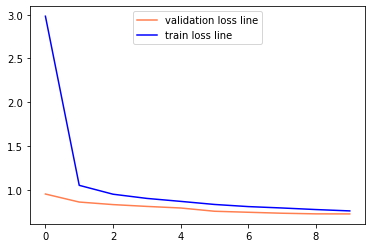

In [47]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], c = 'coral', label = 'validation loss line')
plt.plot(history.history['loss'], c = 'blue', label = 'train loss line')
legend = plt.legend(loc='upper center')
plt.show()

In [51]:
question = ["chào bạn"]
question_seq = tokenizer.texts_to_sequences(question)
question_seq = pad_sequences(question_seq, maxlen=maxlen, padding='post', truncating='post')

answer_seq = model.predict(question_seq)
answer = np.argmax(answer_seq, axis=-1)
answer = tokenizer.sequences_to_texts(answer)
print(answer[0].replace(' <OOV>',''))

1/1 [==============================] - 1s 667ms/step
<OOV>
